# Installs & Imports

In [ ]:
!pip install -q arch

In [ ]:
import numpy as np
import pandas as pd
import random
import warnings
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import matplotlib.pyplot as plt

# Utilities

In [ ]:
def suppress_model_warnings(suppress=True):
    # Suppress warnings if the flag is True
    if suppress:
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
def pp_test(series, alpha=0.05):
    """
    Perform the Phillips–Perron test for stationarity.
    Returns: (is_stationary, p_value)
    """
    try:
        pp = PhillipsPerron(series, lags='auto', trend='c')
        p_value = pp.pvalue
        return (p_value < alpha, p_value)
    except:
        # If something fails, assume nonstationary
        return (False, 1.0)

In [ ]:
def de_shift_series(reconstructed, N, start_timestamp, freq='MS'):
    # The reconstructed series is centered at index N-1
    center_time = start_timestamp + pd.DateOffset(months=N-1)
    new_index = pd.date_range(
        start=center_time - pd.DateOffset(
            months=N-1
        ),
        periods=len(reconstructed),
        freq=freq
    )
    return pd.Series(reconstructed, index=new_index)

In [ ]:
def rmse(y_true, y_pred):
    """
    Root Mean Squared Error.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [ ]:
def mae(y_true, y_pred):
    """
    Mean Absolute Error.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def mape(y_true, y_pred, eps=1e-9):
    """
    Mean Absolute Percentage Error (%).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

In [ ]:
def smape(y_true, y_pred, eps=1e-9):
    """
    Symmetric Mean Absolute Percentage Error (%).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

# HankelTransformer

In [ ]:
class SquareHankelTransformer:
    def __init__(self, N):
        self.N = N  # Size of the square Hankel matrix

    def build_matrix(self, series):
        T = len(series)
        # Ensure the series has enough data to form a square Hankel matrix
        if T < 2 * self.N - 1:
            raise ValueError(f"Series length {T} is less than required {2*self.N - 1} for square Hankel embedding")
        M = np.zeros((self.N, self.N))
        # Build the Hankel matrix using consecutive elements of the series
        for i in range(self.N):
            for j in range(self.N):
                M[i, j] = series[i + j]
        return M

    def reconstruct(self, H):
        # Perform diagonal (skew-diagonal) averaging to reconstruct a series of length 2N-1
        N = H.shape[0]
        T = 2 * N - 1
        y = np.zeros(T)
        counts = np.zeros(T)
        for i in range(N):
            for j in range(N):
                y[i+j] += H[i, j]
                counts[i+j] += 1
        return y / counts

# EVDHM

In [ ]:
class EVDHM:
    def __init__(self, hankel_transformer):
        self.hankel = hankel_transformer  # Use the provided square Hankel transformer

    def decompose_vital(self, series):
        """
        Build a square Hankel matrix from the series and perform eigen-decomposition
        Compute total energy as the sum of absolute eigenvalues
        Select the minimal set of vital eigenvalue pairs (assumed as the i-th and (N-i-1)-th)
        so that their cumulative energy is at least 95% of the total energy
        For each vital pair, form a new diagonal eigenvalue matrix (retaining only those two eigenvalues)
        Reconstruct H_s_i = ν_s * Γ_s_i * ν_s^T and obtain the subseries via diagonal averaging
        Returns a list of vital subcomponents
        """
        M = self.hankel.build_matrix(series)
        N = M.shape[0]
        eigvals, eigvecs = np.linalg.eigh(M)
        # Sort eigenvalues (and corresponding eigenvectors) in descending order
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        total_energy = np.sum(np.abs(eigvals))
        cum_energy = 0.0
        vital_pairs = []
        # Loop over pairs (i and N-i-1) to capture dominant energy
        for i in range(0, N//2):
            pair_energy = np.abs(eigvals[i]) + np.abs(eigvals[N-i-1])
            cum_energy += pair_energy
            vital_pairs.append(i)
            if cum_energy / total_energy >= 0.95:
                break
        # Include the middle eigenvalue if N is odd and threshold is not met
        if N % 2 == 1 and cum_energy/total_energy < 0.95:
            vital_pairs.append(N//2)
        vital_components = []
        # Reconstruct each vital component from the selected eigenvalue pair
        for i in vital_pairs:
            Gamma = np.zeros((N, N))
            Gamma[i, i] = eigvals[i]
            Gamma[N-i-1, N-i-1] = eigvals[N-i-1]
            H_s_i = eigvecs @ Gamma @ eigvecs.T
            comp_series = self.hankel.reconstruct(H_s_i)
            vital_components.append(comp_series)
        return vital_components

# GA Optimizer

In [ ]:
class GAOptimizer:
    def __init__(
        self,
        time_series,
        model_type="ARIMA",  # Accepts "ARIMA" or "SARIMAX"
        seasonal_period=12,
        scoring_metric='AIC',  # Use "AIC" or "MAPE" as fitness metric
        val_size=12,
        p_range=(0, 5),
        d_range=(0, 2),
        q_range=(0, 5),
        # Seasonal ranges only used if model_type is SARIMAX
        P_range=(0, 2),
        D_range=(0, 1),
        Q_range=(0, 2),
        population_size=20,
        n_generations=10,
        mutation_rate=0.1,
        selection_method='tournament',  # "tournament" or "roulette"
        two_point_crossover=False,
        early_stopping_patience=3,
        mutation_decay=0.0,
        verbose=False
    ):
        self.model_type = model_type.upper()  # Ensure model type is uppercase
        self.series = np.array(time_series)
        self.seasonal_period = seasonal_period  # Used if model_type is SARIMAX
        self.scoring_metric = scoring_metric
        self.val_size = val_size
        # Save the nonseasonal ranges
        self.p_range = p_range
        self.d_range = d_range
        self.q_range = q_range
        # Save the seasonal ranges if SARIMAX is used
        if self.model_type == "SARIMAX":
            self.P_range = P_range
            self.D_range = D_range
            self.Q_range = Q_range
        self.population_size = population_size
        self.n_generations = n_generations
        self.base_mutation_rate = mutation_rate
        self.selection_method = selection_method
        self.two_point_crossover = two_point_crossover
        self.early_stopping_patience = early_stopping_patience
        self.mutation_decay = mutation_decay
        self.verbose = verbose
        self.score_cache = {}
        # If using MAPE and enough data is present, split into training and test sets
        if scoring_metric == 'MAPE' and len(self.series) > self.val_size:
            self.train = self.series[:-self.val_size]
            self.test = self.series[-self.val_size:]
        else:
            self.train = self.series
            self.test = None

    def is_valid_candidate(self, candidate):
        # For SARIMAX, candidate is (p, d, q, P, D, Q); for ARIMA, candidate is (p, d, q)
        if self.model_type == "SARIMAX":
            p, d, q, P, D, Q = candidate
            if any(x < 0 for x in candidate):
                return False
            if d + D > 3:
                return False
            if p + q + P + Q > 12:
                return False
        else:
            p, d, q = candidate
            if any(x < 0 for x in candidate):
                return False
            if d > 3:
                return False
            if p + q > 12:
                return False
        return True

    def get_mutation_rate(self, gen):
        # Compute mutation rate with optional exponential decay
        if self.mutation_decay > 0:
            return self.base_mutation_rate * np.exp(-self.mutation_decay * gen)
        else:
            return max(0.0, self.base_mutation_rate * (1 - gen / self.n_generations))

    def fit_model_get_score(self, candidate):
        # If candidate is already evaluated, return its score
        if candidate in self.score_cache:
            return self.score_cache[candidate]
        if not self.is_valid_candidate(candidate):
            self.score_cache[candidate] = 1e15
            return 1e15
        try:
            if self.model_type == "SARIMAX":
                # For SARIMAX, candidate is (p,d,q,P,D,Q)
                p, d, q, P, D, Q = candidate
                order = (p, d, q)
                seasonal_order = (P, D, Q, self.seasonal_period)
                model = SARIMAX(
                    self.train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
            else:
                # For ARIMA, candidate is (p,d,q)
                p, d, q = candidate
                order = (p, d, q)
                model = ARIMA(self.train, order=order)
            results = model.fit()
            if self.scoring_metric == 'AIC':
                score = results.aic
            elif self.scoring_metric == 'MAPE' and self.test is not None:
                forecast_vals = results.forecast(steps=len(self.test))
                score = mape(self.test, forecast_vals)
            else:
                score = results.aic
        except Exception:
            score = 1e15
        self.score_cache[candidate] = score
        return score

    def initialize_population(self):
        # Randomly generate an initial population of candidate orders
        population = []
        if self.model_type == "SARIMAX":
            # Candidate is (p, d, q, P, D, Q)
            for _ in range(self.population_size):
                p = random.randint(*self.p_range)
                d = random.randint(*self.d_range)
                q = random.randint(*self.q_range)
                P = random.randint(*self.P_range)
                D = random.randint(*self.D_range)
                Q = random.randint(*self.Q_range)
                population.append((p, d, q, P, D, Q))
        else:
            # Candidate is (p, d, q)
            for _ in range(self.population_size):
                p = random.randint(*self.p_range)
                d = random.randint(*self.d_range)
                q = random.randint(*self.q_range)
                population.append((p, d, q))
        return population

    def evaluate_population(self, population):
        # Evaluate each candidate's fitness
        scores = []
        for indiv in population:
            sc = self.fit_model_get_score(indiv)
            scores.append((indiv, sc))
        return scores

    def tournament_selection(self, scored_pop, tournament_size=3):
        # Randomly select a few candidates and return the one with the best (lowest) score
        contenders = random.sample(scored_pop, tournament_size)
        best = min(contenders, key=lambda x: x[1])
        return best[0]

    def roulette_selection(self, scored_pop):
        # Perform roulette wheel selection based on inverse score as fitness
        fitnesses = []
        for (ind, sc) in scored_pop:
            fitness = 1.0 / (sc + 1.0)
            fitnesses.append(fitness)
        total_fit = sum(fitnesses)
        pick = random.random() * total_fit
        current = 0.0
        for i, (ind, sc) in enumerate(scored_pop):
            current += fitnesses[i]
            if current >= pick:
                return ind
        return scored_pop[-1][0]

    def select_parent(self, scored_pop):
        # Select a parent using the chosen selection method
        if self.selection_method == 'tournament':
            return self.tournament_selection(scored_pop, tournament_size=3)
        else:
            return self.roulette_selection(scored_pop)

    def crossover(self, parent1, parent2):
        # Perform crossover between two candidate orders
        if self.two_point_crossover:
            c1 = list(parent1)
            c2 = list(parent2)
            length = len(parent1)
            pts = sorted(random.sample(range(1, length), 2))
            start, end = pts[0], pts[1]
            for i in range(start, end):
                c1[i], c2[i] = c2[i], c1[i]
            return tuple(c1), tuple(c2)
        else:
            child1, child2 = [], []
            for i in range(len(parent1)):
                if random.random() < 0.5:
                    child1.append(parent1[i])
                    child2.append(parent2[i])
                else:
                    child1.append(parent2[i])
                    child2.append(parent1[i])
            return tuple(child1), tuple(child2)

    def mutation(self, candidate, mutation_rate):
        # Mutate a candidate order with a given mutation rate
        if self.model_type == "SARIMAX":
            p, d, q, P, D, Q = candidate
            if random.random() < mutation_rate:
                p = random.randint(*self.p_range)
            if random.random() < mutation_rate:
                d = random.randint(*self.d_range)
            if random.random() < mutation_rate:
                q = random.randint(*self.q_range)
            if random.random() < mutation_rate:
                P = random.randint(*self.P_range)
            if random.random() < mutation_rate:
                D = random.randint(*self.D_range)
            if random.random() < mutation_rate:
                Q = random.randint(*self.Q_range)
            return (p, d, q, P, D, Q)
        else:
            p, d, q = candidate
            if random.random() < mutation_rate:
                p = random.randint(*self.p_range)
            if random.random() < mutation_rate:
                d = random.randint(*self.d_range)
            if random.random() < mutation_rate:
                q = random.randint(*self.q_range)
            return (p, d, q)

    def optimize(self):
        # Perform the genetic algorithm optimization for model order selection
        population = self.initialize_population()
        scored_pop = self.evaluate_population(population)
        scored_pop.sort(key=lambda x: x[1])
        best_candidate, best_score = scored_pop[0]
        if self.verbose:
            print(f"\n[GA] Gen 0 best: {best_candidate}, Score={best_score:.4f}")
        no_improvement_count = 0
        best_score_overall = best_score
        for gen in range(1, self.n_generations + 1):
            new_population = [best_candidate]  # Elitism: keep the best candidate
            current_mut_rate = self.get_mutation_rate(gen)
            while len(new_population) < self.population_size:
                parent1 = self.select_parent(scored_pop)
                parent2 = self.select_parent(scored_pop)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutation(child1, current_mut_rate)
                child2 = self.mutation(child2, current_mut_rate)
                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)
            scored_pop = self.evaluate_population(new_population)
            scored_pop.sort(key=lambda x: x[1])
            best_candidate, best_score = scored_pop[0]
            if self.verbose:
                print(f"[GA] Gen {gen} best: {best_candidate}, Score={best_score:.4f}, mutation_rate={current_mut_rate:.4f}")
            if best_score < best_score_overall - 1e-9:
                best_score_overall = best_score
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            if no_improvement_count >= self.early_stopping_patience:
                if self.verbose:
                    print(f"[GA] Early stopping at generation {gen}")
                break
        return best_candidate, best_score

# EVDHM Model

In [ ]:
class EVDHM_Model:
    def __init__(
        self,
        series,
        N,  # Size of the square Hankel matrix; H will be N×N and reconstructed components will be of length 2N-1
        model_type="ARIMA",  # "ARIMA" or "SARIMAX"
        seasonal_period=12,  # Used when model_type is SARIMAX
        alpha=0.05,  # Significance level for the PP test
        ga_params=None,  # Dictionary of GA parameters
        verbose=False,  # Whether to print detailed logs
        suppress_warnings=True,  # Whether to suppress model warnings
        max_decomp_iterations=3,  # Maximum iterations for decomposing nonstationary components
        vital_threshold=0.95,  # Fraction of total eigenvalue energy to capture with vital pairs
        deshift=False,
        freq='MS'
    ):
        if isinstance(series, pd.Series):
            self.index = series.index
        else:
            self.index = None
        self.series = np.array(series)
        self.model_type = model_type.upper()  # Ensure uppercase ("ARIMA" or "SARIMAX")
        self.seasonal_period = seasonal_period
        self.alpha = alpha
        self.verbose = verbose
        self.suppress_warnings = suppress_warnings
        self.max_decomp_iterations = max_decomp_iterations
        self.vital_threshold = vital_threshold
        self.N = N
        self.deshift = deshift
        self.freq = freq

        # Suppress model warnings if desired
        if self.suppress_warnings:
            suppress_model_warnings(True)

        # Use only a square Hankel transformer (rectangular not allowed)
        self.hankel_transformer = SquareHankelTransformer(N)
        self.evdhm = EVDHM(self.hankel_transformer)

        # Set default GA parameters if none provided; include seasonal ranges if SARIMAX is selected
        if ga_params is None:
            if self.model_type == "SARIMAX":
                ga_params = {
                    'scoring_metric': 'AIC',
                    'val_size': 12,
                    'p_range': (0, 5),
                    'd_range': (0, 2),
                    'q_range': (0, 5),
                    'P_range': (0, 2),
                    'D_range': (0, 1),
                    'Q_range': (0, 2),
                    'population_size': 20,
                    'n_generations': 10,
                    'mutation_rate': 0.1,
                    'selection_method': 'tournament',
                    'two_point_crossover': False,
                    'early_stopping_patience': 3,
                    'mutation_decay': 0.0,
                    'verbose': verbose
                }
            else:
                ga_params = {
                    'scoring_metric': 'AIC',
                    'val_size': 12,
                    'p_range': (0, 5),
                    'd_range': (0, 2),
                    'q_range': (0, 5),
                    'population_size': 20,
                    'n_generations': 10,
                    'mutation_rate': 0.1,
                    'selection_method': 'tournament',
                    'two_point_crossover': False,
                    'early_stopping_patience': 3,
                    'mutation_decay': 0.0,
                    'verbose': verbose
                }
        self.ga_params = ga_params

        # Initialize attributes to store details and model outputs
        self.details = {}
        self.fitted_values = None  # Overall in-sample fitted values (summed from subcomponents)
        self.forecast_values = None  # Composite forecast from subcomponent models
        self.component_models = []  # List to store ARIMA/SARIMAX results objects for each final subcomponent
        self.component_series = []  # The corresponding final decomposed subseries
        self.is_overall_stationary = None  # Flag indicating if the original series is stationary
        self.fitted_model = None  # Single model if the series is stationary

    def decompose_iteratively(self, series):
        """
        Perform BFS-style iterative decomposition using vital eigenvalue-based selection
        For each nonstationary component (based on PP test), decompose using decompose_vital until
        the component becomes stationary or the maximum iteration count is reached
        Returns a list of final subcomponents (each reconstructed via diagonal averaging)
        """
        final_components = []
        queue = [(series, 1)]  # Each queue item is a tuple (subseries, iteration number)
        while queue:
            comp_series, iteration = queue.pop(0)
            stat, _ = pp_test(comp_series, alpha=self.alpha)
            if stat or iteration >= self.max_decomp_iterations:
                final_components.append(comp_series)
            else:
                # Decompose nonstationary component using vital eigenvalue pair selection
                vital_subcomps = self.evdhm.decompose_vital(comp_series)
                if self.verbose:
                    print(f"[EVDHM] Iteration {iteration}: decomposed one component into {len(vital_subcomps)} vital subcomponent(s)")
                for sub in vital_subcomps:
                    queue.append((sub, iteration + 1))
        if self.verbose:
            n_nonstat = sum(1 for comp in final_components if not pp_test(comp, alpha=self.alpha)[0])
            print(f"[EVDHM] Final decomposition: {len(final_components)} components, {n_nonstat} remain nonstationary")
        return final_components

    def _fit_ga_model(self, comp_series):
        # Create a GAOptimizer instance for the given subseries and optimize model order
        optimizer = GAOptimizer(
            comp_series,
            model_type=self.model_type,
            seasonal_period=self.seasonal_period,
            scoring_metric=self.ga_params['scoring_metric'],
            val_size=self.ga_params['val_size'],
            p_range=self.ga_params['p_range'],
            d_range=self.ga_params['d_range'],
            q_range=self.ga_params['q_range'],
            **({
                'P_range': self.ga_params['P_range'],
                'D_range': self.ga_params['D_range'],
                'Q_range': self.ga_params['Q_range']
            } if self.model_type == "SARIMAX" else {}),
            population_size=self.ga_params['population_size'],
            n_generations=self.ga_params['n_generations'],
            mutation_rate=self.ga_params['mutation_rate'],
            selection_method=self.ga_params['selection_method'],
            two_point_crossover=self.ga_params['two_point_crossover'],
            early_stopping_patience=self.ga_params['early_stopping_patience'],
            mutation_decay=self.ga_params['mutation_decay'],
            verbose=self.ga_params['verbose']
        )
        return optimizer.optimize()

    def fit(self):
        # Check if the overall series is stationary using the PP test
        is_stat, pval = pp_test(self.series, alpha=self.alpha)
        self.is_overall_stationary = is_stat
        self.details['original_stationary'] = is_stat
        self.details['original_pp_value'] = pval

        if is_stat:
            # If stationary, fit a single model on the entire series
            if self.verbose:
                print("[EVDHM-Model] Series is stationary. Fitting single GA-based model")
            best_params, best_score = self._fit_ga_model(self.series)
            self.details['overall_order'] = best_params
            self.details['overall_score'] = best_score
            if self.model_type == "SARIMAX":
                p, d, q, P, D, Q = best_params
                order = (p, d, q)
                seasonal_order = (P, D, Q, self.seasonal_period)
                model = SARIMAX(
                    self.series,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
            else:
                p, d, q = best_params
                order = (p, d, q)
                model = ARIMA(self.series, order=order)
            self.fitted_model = model.fit()
            self.fitted_values = self.fitted_model.fittedvalues
        else:
            # If nonstationary, apply iterative vital EVD decomposition
            if self.verbose:
                print("[EVDHM-Model] Series is nonstationary. Performing iterative vital EVD decomposition")
            final_subcomponents = self.decompose_iteratively(self.series)
            fitted_components = []
            comp_orders = []
            # For each final subcomponent, optimize model order using GA and fit a model
            for i, comp in enumerate(final_subcomponents):
                if self.deshift and (self.index is not None):
                    comp = de_shift_series(
                        comp,
                        self.N,
                        self.index[0],
                        freq=self.freq
                    ).values
                stat, pval = pp_test(comp, alpha=self.alpha)
                if self.verbose:
                    print(f"[EVDHM-Model] Final component {i+1}/{len(final_subcomponents)}: stationary={stat}, pval={pval:.4g}. Fitting GA-based model")
                best_params, best_score = self._fit_ga_model(comp)
                comp_orders.append((best_params, best_score))
                if self.model_type == "SARIMAX":
                    p, d, q, P, D, Q = best_params
                    order = (p, d, q)
                    seasonal_order = (P, D, Q, self.seasonal_period)
                    model = SARIMAX(
                        comp,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                else:
                    p, d, q = best_params
                    order = (p, d, q)
                    model = ARIMA(comp, order=order)
                fit_res = model.fit()
                fitted_components.append(fit_res.fittedvalues)
                self.component_models.append(fit_res)
                self.component_series.append(comp)
            self.details['component_orders'] = comp_orders
            # Sum the fitted values from all final subcomponents for overall in-sample reconstruction
            self.fitted_values = np.sum(fitted_components, axis=0)
        return self

    def forecast(self, steps=12):
        # Forecast using the overall fitted model if the series is stationary
        if self.is_overall_stationary and self.fitted_model is not None:
            fc = self.fitted_model.forecast(steps=steps)
            self.forecast_values = fc
        else:
            # Otherwise, forecast each subcomponent and sum their forecasts to obtain the composite forecast
            comp_forecasts = []
            for model, comp in zip(self.component_models, self.component_series):
                fc = model.forecast(steps=steps)
                comp_forecasts.append(fc)
            self.forecast_values = np.sum(comp_forecasts, axis=0)

        if self.deshift and (self.index is not None):
            lag_offset = self.N-1
            forecast_start_date = self.index[-1] + pd.DateOffset(months=1)
            adjusted_start_date = forecast_start_date - pd.DateOffset(months=lag_offset)
            aligned_forecast_index = pd.date_range(
                start=adjusted_start_date,
                periods=len(self.forecast_values),
                freq=self.freq
            )
            self.forecast_values = pd.Series(self.forecast_values, index=aligned_forecast_index)
        return self.forecast_values

# Data Loading

In [ ]:
# Load airline passenger data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=["Month"], index_col="Month")
series = df["Passengers"]

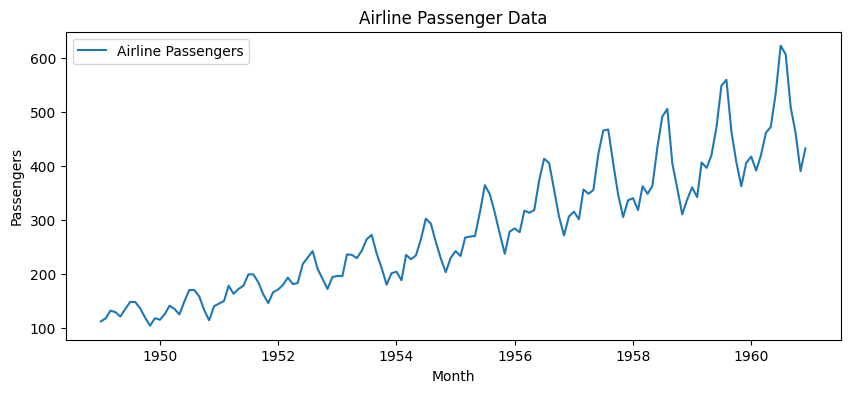

In [ ]:
# Plot the entire series
plt.figure(figsize=(10, 4))
plt.plot(series, label="Airline Passengers")
plt.title("Airline Passenger Data")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()
plt.show()

# Data Preparation

In [ ]:
# Split dataset: last 24 values as test set (forecast horizon)
test_size = 24
train_series = series[:-test_size]
test_series = series[-test_size:]
print(f"Training set length: {len(train_series)}, Test set length: {len(test_series)}")

Training set length: 120, Test set length: 24


In [ ]:
# Log transformation
train_series = pd.Series(np.log(train_series))
test_series = pd.Series(np.log(test_series))

# Model Fitting

In [ ]:
# Define GA parameters
ga_params = {
    'scoring_metric': 'AIC',    # choose 'AIC' or 'MAPE'
    'val_size': 12,             # used if scoring_metric == 'MAPE'
    'p_range': (0, 5),
    'd_range': (0, 2),
    'q_range': (0, 5),
    'P_range': (0, 2),
    'D_range': (0, 1),
    'Q_range': (0, 2),
    'population_size': 20,
    'n_generations': 5,
    'mutation_rate': 0.99,
    'selection_method': 'tournament',  # 'tournament' or 'roulette'
    'two_point_crossover': True,
    'early_stopping_patience': 3,
    'mutation_decay': 0.05,   # exponential decay rate; set 0 for linear
    'verbose': True
}

In [ ]:
# Fit the model
T = len(train_series)
N = (T + 1) // 2
model_type = "ARIMA"
model = EVDHM_Model(
    train_series,
    N=N,
    model_type=model_type,
    seasonal_period=12,
    alpha=0.05,
    ga_params=ga_params,
    max_decomp_iterations=3,
    vital_threshold=0.95,
    verbose=False,
    suppress_warnings=True,
    deshift=False,
    freq='MS'
)
model.fit()


[GA] Gen 0 best: (5, 0, 1), Score=-1438.7010
[GA] Gen 1 best: (5, 0, 1), Score=-1438.7010, mutation_rate=0.9417
[GA] Gen 2 best: (5, 0, 1), Score=-1438.7010, mutation_rate=0.8958
[GA] Gen 3 best: (5, 0, 1), Score=-1438.7010, mutation_rate=0.8521
[GA] Early stopping at generation 3

[GA] Gen 0 best: (2, 1, 2), Score=-1532.1873
[GA] Gen 1 best: (2, 1, 4), Score=-1539.6496, mutation_rate=0.9417
[GA] Gen 2 best: (2, 1, 4), Score=-1539.6496, mutation_rate=0.8958
[GA] Gen 3 best: (2, 1, 4), Score=-1539.6496, mutation_rate=0.8521
[GA] Gen 4 best: (2, 1, 4), Score=-1539.6496, mutation_rate=0.8105
[GA] Early stopping at generation 4

[GA] Gen 0 best: (3, 1, 3), Score=-1553.3786
[GA] Gen 1 best: (5, 0, 4), Score=-1614.5720, mutation_rate=0.9417
[GA] Gen 2 best: (3, 0, 4), Score=-1653.0971, mutation_rate=0.8958
[GA] Gen 3 best: (3, 0, 4), Score=-1653.0971, mutation_rate=0.8521
[GA] Gen 4 best: (3, 0, 4), Score=-1653.0971, mutation_rate=0.8105
[GA] Gen 5 best: (3, 0, 4), Score=-1653.0971, mutatio

In [ ]:
# Print details
print("=== Model Details ===")
print("Initially Stationary? ", model.details['original_stationary'])
print("PP p-value: ", model.details['original_pp_value'])
if 'component_orders' in model.details:
    print("Component orders:")
    for cinfo in model.details['component_orders']:
        print(" ", cinfo)

=== Model Details ===
Initially Stationary?  False
PP p-value:  1.0
Component orders:
  ((5, 0, 1), -1438.7009938705562)
  ((2, 1, 4), -1539.649597770295)
  ((3, 0, 4), -1653.0971181633577)
  ((5, 1, 3), -1713.4454672119416)
  ((3, 0, 4), -1708.7563640858818)
  ((5, 0, 4), -1785.1488918316177)
  ((4, 1, 3), -1918.797596328199)
  ((2, 1, 4), -1482.3976821449583)
  ((4, 0, 1), -1585.707303146736)


# Metrics Evaluation

In [ ]:
# Forecast the next 24 values (test set horizon)
forecast_vals = model.forecast(steps=test_size)

In [ ]:
# Inverse transformation
forecast_vals = pd.Series(np.exp(forecast_vals))
train_series = pd.Series(np.exp(train_series))
test_series = pd.Series(np.exp(test_series))

In [ ]:
# Compute forecast evaluation metrics on the test set
rmse_val = rmse(test_series, forecast_vals)
mae_val = mae(test_series, forecast_vals)
mape_val = mape(test_series, forecast_vals)
smape_val = smape(test_series, forecast_vals)

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE', 'SMAPE'],
    'Value': [rmse_val, mae_val, mape_val, smape_val]
})
print("=== Forecast Evaluation Metrics ===")
display(metrics_df)

=== Forecast Evaluation Metrics ===


,Metric,Value
0,RMSE,66.571212
1,MAE,55.128708
2,MAPE,12.957363
3,SMAPE,11.831242


# Forecast Plotting

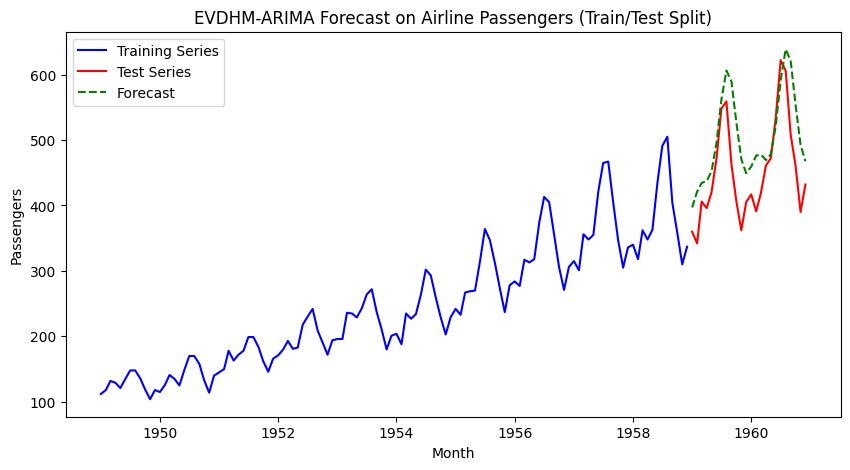

In [ ]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label="Training Series", color="blue")
plt.plot(test_series.index, test_series, label="Test Series", color="red")
last_date = train_series.index[-1]
forecast_index = pd.date_range(last_date, periods=test_size+1, freq='MS')[1:]
plt.plot(forecast_index, forecast_vals, label="Forecast", color="green",  linestyle="--")
plt.title("EVDHM-ARIMA Forecast on Airline Passengers (Train/Test Split)")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()
plt.show()